In [1]:
from __future__ import annotations

import numpy as np
from sklearn.datasets import load_digits
from scipy import stats

from abc import abstractmethod
from dataclasses import dataclass
from typing import *

# Base Classes

In [2]:
"""Note: we rewrote some stuff so the code is readable."""

@dataclass
class Node:
    features: np.ndarray
    responses: np.ndarray
        
    # for children
    left: Optional[Node] = None
    right: Optional[Node] = None
    split_index: int = -1
    threshold: float = 0
        
    # for leafs
    prediction: Optional[Any] = None


class Tree:
    def __init__(self, n_min=10):
        """
        n_min: minimum required number of instances in leaf nodes
        """
        self.n_min = n_min
    
    def predict(self, x):
        """Return the prediction for the given 1-D feature vector x."""
        
        # find the leaf containing the 1-D feature vector x
        node = self.root
        while node.prediction is None:
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
                
        # return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        """
        features: the feature matrix of the training set
        response: the vector of responses
        """
        N, D = features.shape
        assert(responses.shape[0] == N)

        # number of features to consider for each split decision
        if D_try is None:
            D_try = int(np.sqrt(D))
        
        # initialize the root node
        self.root = Node(features, responses)

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            
            # attempt to split the node
            active_indices = self.select_active_indices(D, D_try)
            children = self.attempt_split_node(node, active_indices)
            
            # if not successful, it's a leaf
            if children is None:
                self.make_leaf_node(node)
            else:
                l, r = children
                
                stack.append(l)
                stack.append(r)
    
    def attempt_split_node(self, node: Node, indices: np.ndarray) -> Optional[Tuple[Node, Node]]:
        """
        node: the node to be split
        indices: a numpy array containing the feature indices to be considered for the present split
                         
        return: left, right as the children of the split or None if no suitable split exists.
        """
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        # no split found
        if j_min is None:
            return None

        # else we get the children
        left, right = self.make_children(node, j_min, t_min)
        
        # and split this node
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        
        return left, right
    
    def select_active_indices(self, D: int, D_try: int) -> np.ndarray:
        """Return a 1-D array with D_try randomly selected indices from 0...(D-1)."""
        return np.random.choice(D, D_try, replace=False)
        
    def find_thresholds(self, node: Node, j: int) -> np.ndarray:
        """Return a 1-D array with all possible thresholds along feature j."""
        # convolve just acts as an average over a sliding window of size 2 (i.e. midpoints)
        midpoints = np.convolve(sorted(node.features[:,j]), [0.5, 0.5], mode='valid')
        
        # we're only interested in the unique ones
        return np.unique(midpoints)
        
    def make_children(self, node: Node, j: int, t: float) -> Tuple[Node, Node]:
        """Get the children of the node on feature j and threshold t."""
        
        # TODO: vectorize this
        idx = node.features[:,j] <= t
        not_idx = node.features[:,j] > t
        
        left = Node(
            node.features[node.features[:,j] <= t],
            node.responses[idx],
        )
        
        right = Node(
            node.features[not_idx],
            node.responses[not_idx],
        )
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node: Node):
        """Turn node into a leaf by computing and setting `node.prediction`"""
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        """Return the resulting loss when the data are split along feature j at threshold t.
        If the split is not admissible, return float('inf')."""
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")

# Regression Tree

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super().__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        ... # your code here
        raise NotImplementedError("compute_loss_for_split(): remove this exception after adding your code above.")
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = ... # your code here
        raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")


# Classification Tree

In [4]:
from enum import Enum


class ClassificationLossMethod(Enum):
    C4D5 = 1
    CART = 2
    
class ClassificationTree(Tree):
    
    def __init__(self, classes, n_min=10, loss_method = ClassificationLossMethod.C4D5):
        """
        classes: a 1-D array with the permitted class labels
        n_min: minimum required number of instances in leaf nodes
        """
        super().__init__(n_min)
        self.classes = classes
        self.loss_method = self.c4d5 if loss_method == ClassificationLossMethod.C4D5 else self.cart

    def c4d5(self, node):
        if len(node.responses) == 0:
            return float('inf')

        total = 0
        for k in self.classes:
            nz = np.count_nonzero(node.responses == k)

            if nz == 0:
                continue

            p_mk = nz / len(node.responses)
            total += p_mk * np.log(p_mk)
        return total


    def cart(self, node):
        if len(node.responses) == 0:
            return float('inf')

        total = 0
        for k in self.classes:
            nz = np.count_nonzero(node.responses == k)

            if nz == 0:
                continue

            p_mk = nz / len(node.responses)

            total += p_mk ** 2
        return 1 - total
                
    def compute_loss_for_split(self, node, j, t):
        left, right = self.make_children(node, j, t)
                    
        return len(left.responses) * self.loss_method(left) \
             + len(right.responses) * self.loss_method(right)
        
    def make_leaf_node(self, node):
        """Turn node into a leaf node by computing `node.prediction`."""
        node.prediction = stats.mode(node.responses, keepdims=True).mode[0]      

# Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


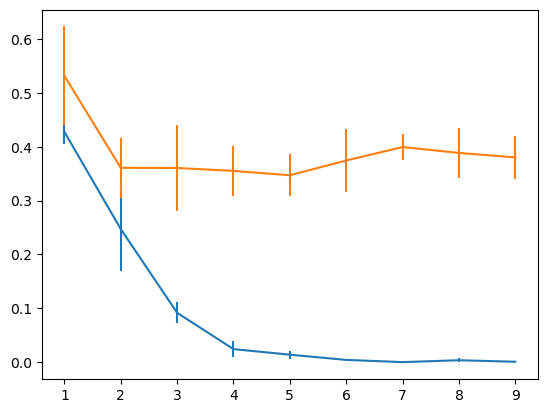

In [6]:
# perform 5-fold cross-validation with labels 3 and 9
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


def error(y, y_hat):
    count = 0
    for k1, k2 in zip(y, y_hat):
        if k1 != k2:
            count += 1
    
    return count / len(y)


train_errors = []
test_errors = []
for D_try in range(1, 10):
    train_errors.append([])
    test_errors.append([])
    
    for train_i, test_i in KFold(n_splits=5).split(features):
        Xtr = features[train_i]
        ytr = labels[train_i]

        Xte = features[test_i]
        yte = labels[test_i]

        # our train/error
        tree = ClassificationTree([3, 9])
        tree.train(Xtr, ytr, D_try=D_try)
        
        train_errors[-1].append(error(ytr, map(tree.predict, Xtr)))
        test_errors[-1].append(error(yte, map(tree.predict, Xte)))
        
plt.errorbar(
    np.arange(len(train_errors)) + 1,
    np.average(train_errors, axis=1),
    np.std(train_errors, axis=1),
)
       
plt.errorbar(
    np.arange(len(test_errors)) + 1,
    np.average(test_errors, axis=1),
    np.std(test_errors, axis=1),
)

plt.show()

In [7]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)

# Regression and Classification Forest

In [ ]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    ... # your code here
    raise NotImplementedError("bootstrap_sampling(): remove this exception after adding your code above.")

In [ ]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        raise NotImplementedError("predict(): remove this exception after adding your code above.")

In [ ]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        raise NotImplementedError("predict(): remove this exception after adding your code above.")

# Evaluation of Regression and Decision Forest

In [ ]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
... # your code here

In [ ]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
... # your code here

# Multi-class Classification Forest

In [ ]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here

# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here